# Quality cut proposal

In [298]:
%matplotlib inline
import matplotlib.pyplot as pl
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
import seaborn as sns

import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm

# A few useful constants
KEPLER_BEGIN_BK, KEPLER_END_BK = 130, 1582

In [2]:
transits = pd.read_hdf('all-long-period-tce-transits-with-ccd-info.h5', key='transits')

In [3]:
transits.head()

,kepid_x,tce,tce_max_mult_ev,tce_period,tce_plnt_num,transit_time_x,quarter,channel,idx,kepid_y,module,output,transit_time_y
0,2304168,002304168-02,12.22,431.719,2,219.298,2.0,4.0,0,2304168,2.0,4.0,219.298
1,2304168,002304168-02,12.22,431.719,2,651.017,7.0,56.0,1,2304168,16.0,4.0,651.017
2,2304168,002304168-02,12.22,431.719,2,1082.736,11.0,56.0,2,2304168,16.0,4.0,1082.736
3,2304168,002304168-02,12.22,431.719,2,1514.455,16.0,84.0,3,2304168,24.0,4.0,1514.455
4,2303102,002303102-10,11.51,480.481,10,161.570,1.0,32.0,4,2303102,10.0,4.0,161.570


14it [00:26,  1.24s/it]


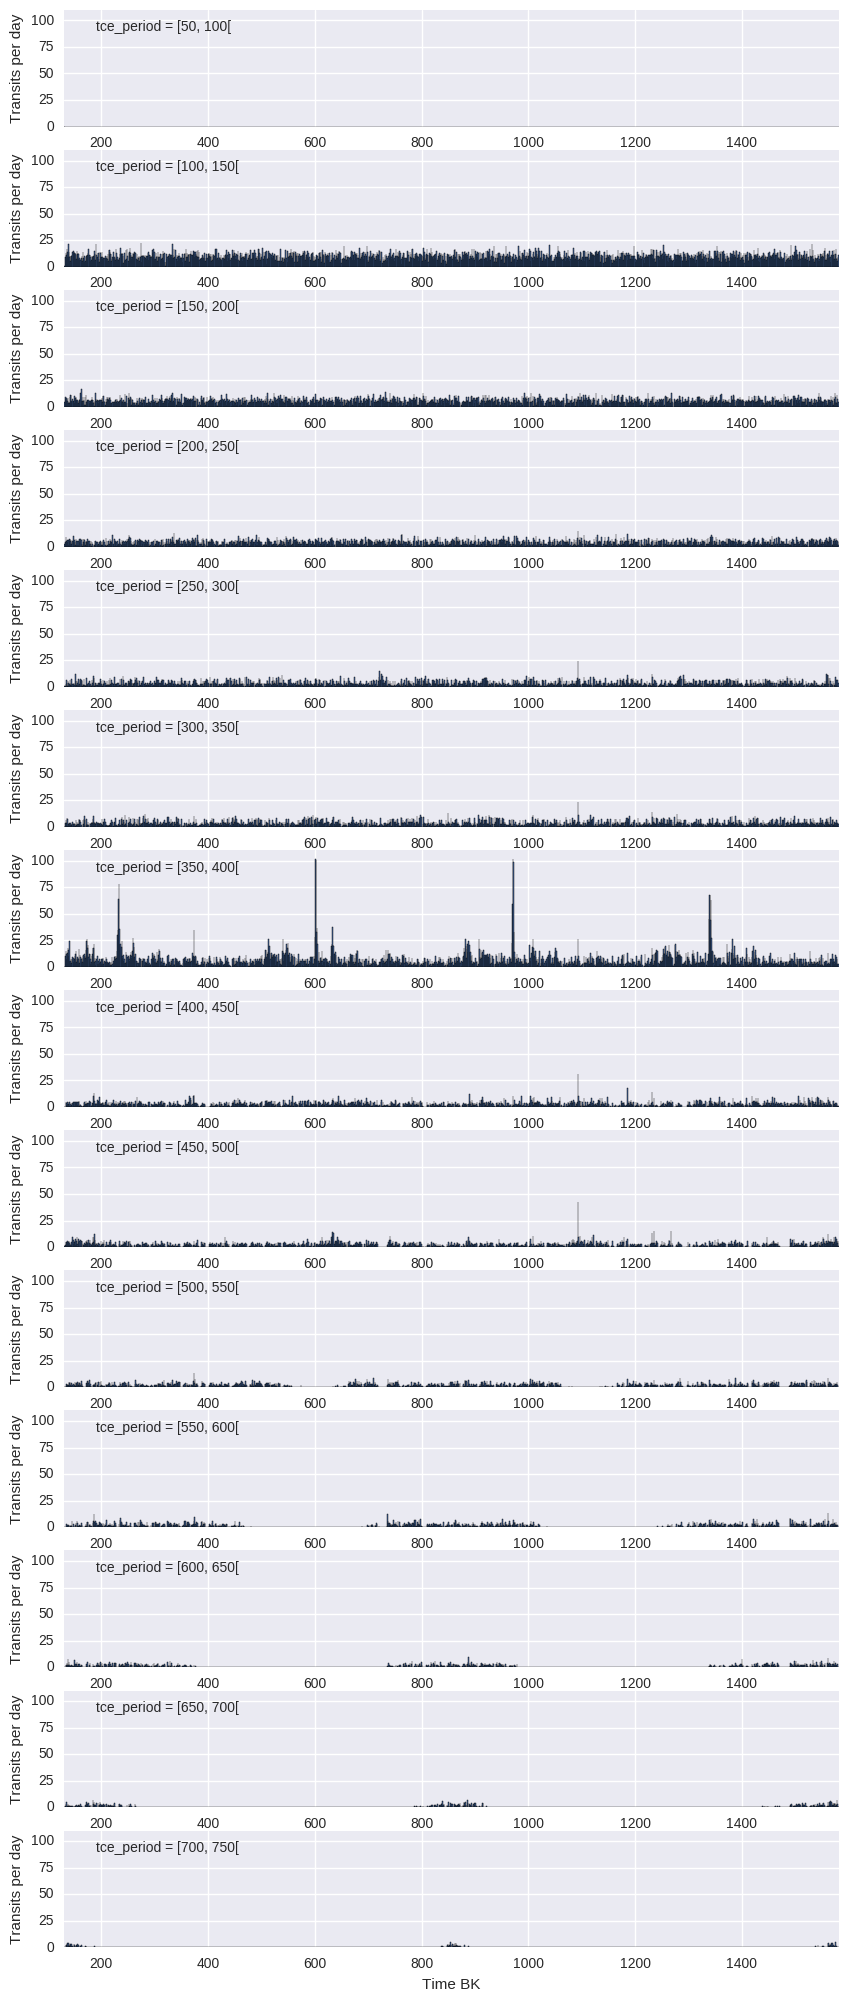

In [15]:
stepsize = 50
boundaries = range(100, 750, stepsize)
pl.figure(figsize=(10, 25))
for idx, bound in tqdm(enumerate(boundaries)):
    mask = (transits.tce_period >= bound) & (transits.tce_period < bound + stepsize)
    pl.subplot(len(boundaries), 1, idx+1)
    _ = pl.hist(transits.transit_time_x[mask],
                range=(KEPLER_BEGIN_BK, KEPLER_END_BK),
                bins=(KEPLER_END_BK - KEPLER_BEGIN_BK))  # 1 bin per day
    pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
    pl.ylim([0, 110])
    pl.yticks(range(0, 101, 25))
    pl.text(190, 90, 'tce_period = [{}, {}['.format(bound, bound+stepsize))
    pl.ylabel('Transits per day')
pl.xlabel('Time BK')
pl.show()

## What is the mean transit rate per day and module?

In [105]:
mask = ~transits['channel'].isnull()
observed = transits[mask].copy()
observed['day'] = observed['transit_time_x'].round().astype(int)
observed['quarter'] = observed['quarter'].astype(int)
observed['channel'] = observed['channel'].astype(int)
observed['module'] = observed['module'].astype(int)

In [98]:
by_module = observed.groupby(by=('module'))

In [106]:
gs = by_module.size()
gs.name = 'transitcount'
newdf = pd.DataFrame(gs)
days_observed = observed.day.unique().size
newdf['transit_freq'] = newdf['transitcount'] / days_observed
newdf

,transitcount,transit_freq
module,,
2,2559,1.797051
3,545,0.382725
4,2709,1.902388
6,2673,1.877107
7,3157,2.216994
8,3270,2.296348
9,4754,3.338483
10,2682,1.883427
11,2702,1.897472


In [228]:
def transit_rate(channel):
    """Determines the mean daily transit rate of a module."""
    mask_channel = observed.channel == channel
    days_with_transits = observed.day.unique()  # For all modules
    first_day = observed[mask_channel].day.min()
    last_day = observed[mask_channel].day.max()
    days_with_transits = days_with_transits[(days_with_transits >= first_day) & (days_with_transits <= last_day)]
    days_with_transits.sort()
    
    transitcounts = observed[mask_channel].groupby(by='day').size()
    
    for day in days_with_transits:
        if day not in transitcounts:
            transitcounts[day] = 0

    tcecount = observed[mask_channel].tce.unique().size
    return transitcounts.mean(), transitcounts.std(), tcecount, transitcounts
    

In [229]:
transit_rate(channel=26)

(1.8043631245601688, 6.247118375058268, 1105, day
 132     1
 133     3
 136     1
 138     1
 141     2
 143     1
 144     2
 145     2
 146     2
 147     2
 148     1
 149     3
 150     3
 152     1
 153     2
 154     1
 155     4
 157     1
 158     2
 159     2
 161     1
 162     3
 164     2
 170     1
 172     3
 173     8
 174     2
 175     3
 178     3
 179     1
        ..
 1513    0
 1514    0
 1515    0
 1516    0
 1517    0
 1518    0
 1519    0
 1521    0
 1524    0
 1525    0
 1530    0
 1533    0
 1534    0
 1535    0
 1537    0
 1540    0
 1545    0
 1548    0
 1550    0
 1552    0
 1554    0
 1558    0
 1559    0
 1560    0
 1562    0
 1565    0
 1568    0
 1574    0
 1577    0
 1578    0
 dtype: int64)

In [231]:
results = []
CHANNELS = list(range(1, 85))
for channel in CHANNELS:
    mean, std, tcecount, transitcounts = transit_rate(channel=channel)
    results.append({'channel': channel, 'mean': mean, 'std': std, 'tcecount': tcecount})
results = pd.DataFrame(results)

In [232]:
results.index = results.channel

In [309]:
results.head()

,candidates,channel,mean,std
channel,,,,
1,338,1,0.409348,0.667880
2,352,2,0.446403,0.768297
3,379,3,0.473647,0.768015
4,376,4,0.475653,0.740958
5,120,5,0.398671,0.622253


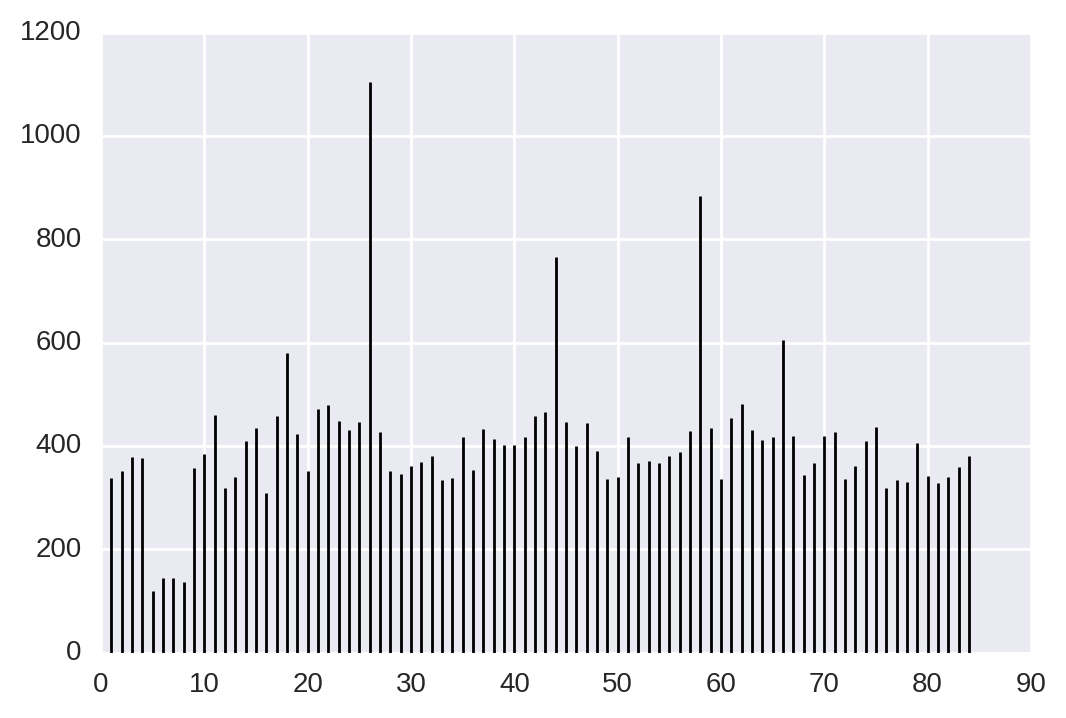

In [318]:
pl.vlines(results.channel, 0, results.candidates, lw=1, alpha=1)
pl.vlines?


day
133    1
134    0
135    0
136    0
137    2
dtype: int64
447
day
132    1
133    3
134    0
135    0
136    1
dtype: int64
1105


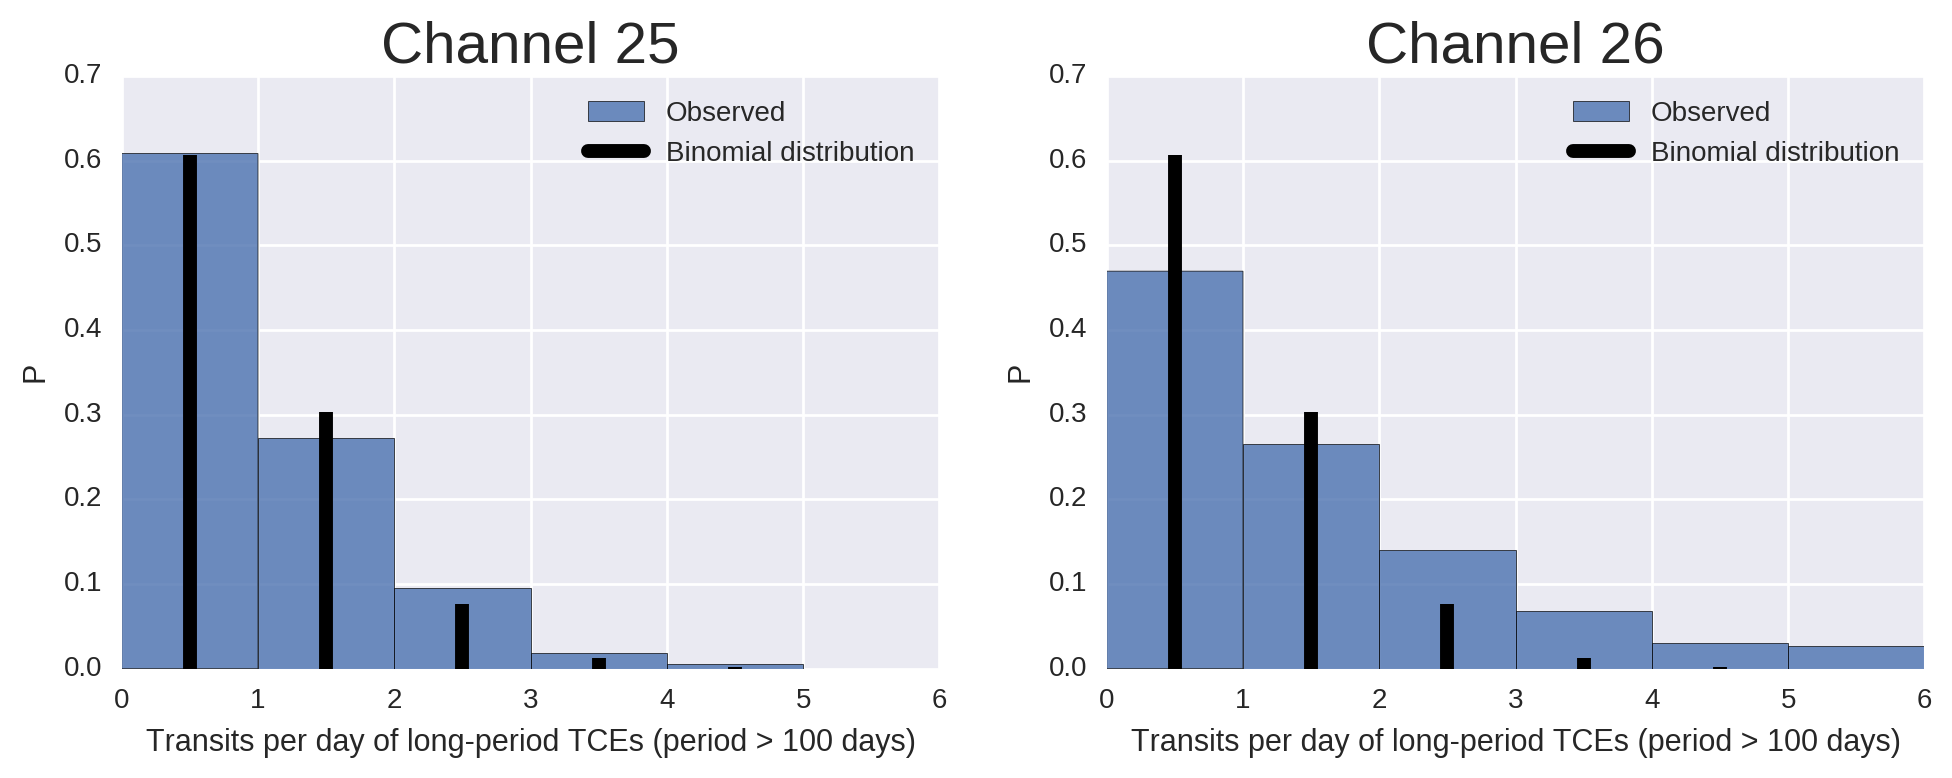

In [306]:
pl.figure(figsize=(10, 4))

pl.subplot(121)
CHANNEL = 25
mean, std, tcecount, transitcount = transit_rate(channel=CHANNEL)
print(transitcount.sort_index().head())
pl.hist(transitcount, normed=True, bins=6, range=(0, 6), label='Observed', alpha=0.8)
print(tcecount)

from scipy.stats import binom
n, p = 500, 0.001
x = np.arange(0, 6)
pl.vlines(x + 0.5, 0, binom.pmf(x, n, p), lw=5, alpha=1, label='Binomial distribution')
pl.title('Channel {}'.format(CHANNEL), fontsize=21)
pl.xlabel('Transits per day of long-period TCEs (period > 100 days)')
pl.ylabel('P')
pl.legend()
          
pl.subplot(122)
CHANNEL = 26
mean, std, tcecount, transitcount = transit_rate(channel=CHANNEL)
print(transitcount.sort_index().head())
pl.hist(transitcount, normed=True, bins=6, range=(0, 6), label='Observed', alpha=0.8)
print(tcecount)

from scipy.stats import binom
n, p = 500, 0.001
x = np.arange(0, 6)
pl.vlines(x + 0.5, 0, binom.pmf(x, n, p), lw=5, alpha=1, label='Binomial distribution')
pl.title('Channel {}'.format(CHANNEL), fontsize=21)
pl.xlabel('Transits per day of long-period TCEs (period > 100 days)')
pl.ylabel('P')
pl.legend()
pl.tight_layout()
pl.savefig('transitrate.png')

In [307]:
transits[transits.channel == 25].head()

,kepid_x,tce,tce_max_mult_ev,tce_period,tce_plnt_num,transit_time_x,quarter,channel,idx,kepid_y,module,output,transit_time_y,transit_time_rounded
10252,5175986,005175986-02,11.420,550.544,2,454.673,5.0,25.0,10252,5175986,9.0,1.0,454.673,455
10323,5176131,005176131-01,7.601,479.762,1,834.632,9.0,25.0,10323,5176131,9.0,1.0,834.632,835
10427,5176547,005176547-02,10.980,281.464,2,534.731,5.0,25.0,10427,5176547,9.0,1.0,534.731,535
10428,5176547,005176547-02,10.980,281.464,2,816.195,9.0,25.0,10428,5176547,9.0,1.0,816.195,816
10431,5176547,005176547-03,14.740,471.826,3,480.635,5.0,25.0,10431,5176547,9.0,1.0,480.635,481


## Does the number of targets vary per channel?

(array([  578.,   633.,   674.,   674.,   120.,   144.,   144.,   137.,
          623.,   645.,   840.,   601.,   621.,   679.,   813.,   560.,
          831.,   887.,   748.,   691.,   854.,   877.,   811.,   728.,
          766.,  2564.,   766.,   658.,   608.,   695.,   678.,   701.,
          617.,   648.,   788.,   649.,   798.,   689.,   701.,   715.,
          705.,   772.,   750.,  1772.,   841.,   666.,   750.,   679.,
          617.,   652.,   788.,   684.,   636.,   695.,   683.,   693.,
          730.,  1787.,   751.,   588.,   827.,   890.,   747.,   718.,
          719.,   919.,   729.,   632.,   651.,   731.,   825.,   640.,
          652.,   658.,   788.,   573.,   624.,   593.,   741.,   589.,
          573.,   599.,  1296.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.

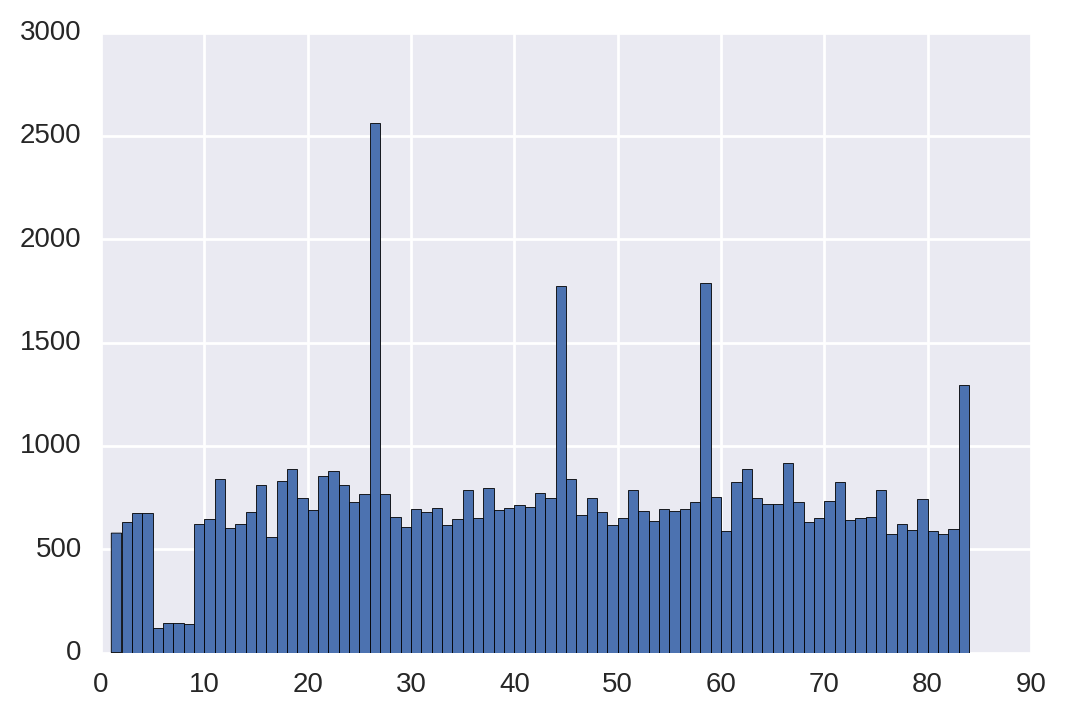

In [314]:
pl.hist(transits.channel[~transits.channel.isnull()], bins=83, range=(1, 84))